> # Modelling
- Mixed Effects Modelling
    - Baseline Model (All Regions) (3 Levels)
    - Region-wise Model (2 Levels)
    - VIF (Multicollinearity)
- Chow's Test

In [ ]:
%load_ext autoreload
%autoreload 2

import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

from jenkspy import jenks_breaks
from scipy import stats

warnings.filterwarnings("ignore")

In [ ]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.labelpad"] = 8
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["xtick.major.pad"] = 8
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["figure.autolayout"] = True
plt.rcParams["legend.fontsize"] = 12

plt.rcParams["legend.edgecolor"] = 'black'

In [ ]:
y = pd.read_csv("data/conflicts/Y_conflicts.csv")
x = pd.read_csv("data/political identities/X.csv")

#Drop NA Average Term Population
x = x.dropna(subset=['Average Term Population'])

In [ ]:
# Merging the two df
df = pd.merge(x, y, left_on = ['country_name', 'year','end_year'], right_on = ['country', 'start_year','end_year'], how = 'right')
df.dropna(inplace=True)

# Remove the regions Western Europe and North America and Eastern Europe and Central Asia 
df = df.loc[~df['region'].isin(['Western Europe and North America', 'Eastern Europe and Central Asia'])]

In [5]:
# Consider counries with more than 2 observations
country_counts = df['country_name'].value_counts()

multiple_obs_countries = country_counts[country_counts > 2].index

df_filtered = df[df['country_name'].isin(multiple_obs_countries)]

In [ ]:

breaks = jenks_breaks(df_filtered['end_year'],4)

bins = pd.cut(df_filtered['year'], bins=[1988,2000,2008,2015,2023], labels=['1989 - 2000', '2001 - 2008', '2009 - 2015', '2016- 2023'])

df_filtered['era'] = bins

In [7]:
breaks

[np.int64(1991),
 np.int64(2000),
 np.int64(2008),
 np.int64(2015),
 np.int64(2023)]

In [8]:
df_filtered.era.unique()

['1989 - 2000', '2001 - 2008', '2009 - 2015', '2016- 2023']
Categories (4, object): ['1989 - 2000' < '2001 - 2008' < '2009 - 2015' < '2016- 2023']

In [9]:
polarization_columns = [
    'Anti-Elitism Polarization', 'People-Centrism Polarization',
    'Political Opponents Polarization', 'Political Pluralism Polarization',
    'Minority Rights Polarization', 'Rejection of Political Violence Polarization',
    'Immigration Polarization', 'LGBT Social Equality Polarization',
    'Cultural Superiority Polarization', 'Religious Principles Polarization',
    'Gender Equality Polarization', 'Working Women Polarization',
    'Economic Left-Right Scale Polarization', 'Welfare Polarization',
    'Clientelism Polarization'
]
control_variables = ['Average Term Population', 'period_length',
       'Freedom of Expression', 'Religious Freedom', 'GDP per Capita',
       'Gini Index']

dependent_variables = ['events_rate','deaths_rate']

predictors = polarization_columns + control_variables

In [10]:
df_filtered.region.unique()

array(['Middle East and North Africa', 'Sub-Saharan Africa',
       'Latin America and the Caribbean', 'Asia and Pacific'],
      dtype=object)

# Mixed Effects Modelling

### Data Prep for Mixed Effects Nested Structure

In [ ]:
def test_heteroskedasticity(model):
    """
    Breusch-Pagan test on the model residuals
    """
    from statsmodels.stats.diagnostic import het_breuschpagan
    
    resid = model.resid
    exog = model.model.exog

    bp_test = het_breuschpagan(resid, exog)
    
    return {
        'bp_statistic': bp_test[0],
        'bp_pvalue': bp_test[1]
    }

In [12]:
def calculate_r2(model):
    """Calculate Marginal, Conditional and Adjusted R2 for mixed effects model"""
    n = len(model.fittedvalues)
    p = len(model.fe_params)  # number of fixed effects parameters
    
    fixed_effects_variance = np.var(model.fittedvalues)
    random_effects_variance = model.cov_re.iloc[0, 0]
    residual_variance = model.scale
    
    R2_m = fixed_effects_variance / (fixed_effects_variance + random_effects_variance + residual_variance)
    R2_c = (fixed_effects_variance + random_effects_variance) / (fixed_effects_variance + random_effects_variance + residual_variance)
    
    # Adjusted R2
    R2_adj = 1 - ((1 - R2_m) * (n - 1) / (n - p - 1))
    
    return {
        'R2_marginal': R2_m,
        'R2_conditional': R2_c,
        'R2_adjusted': R2_adj,
    }

In [13]:
def prepare_data(df, prediction_column, predictors, region=None):
    """
    Prepare data for multilevel modeling
    """
    data = df.copy()

    if region!=None:
        data = data[data['Region'] == region]

    data.reset_index(inplace=True)
    
    # # Standardize numeric predictors
    # for col in predictors:
    #     if data[col].dtype in ['int64', 'float64']:
    #         data[col] = (data[col] - data[col].mean()) / data[col].std()
    
    # # Standardize response variable
    # data[prediction_column] = (data[prediction_column] - data[prediction_column].mean()) / data[prediction_column].std()

    data['country_id'] = pd.Categorical(data['country_name']).codes
    data['era_id'] = pd.Categorical(data['era']).codes
    
    # Create unique identifiers for each level
    if region==None:
        data['region_id'] = pd.Categorical(data['Region']).codes
        # Create nested grouping identifiers
        data['country_region'] = data['country_id'].astype(str) + "_" + data['region_id'].astype(str)
    

    # Create nested grouping identifiers
    data['era_country'] = data['era_id'].astype(str) + "_" + data['country_id'].astype(str)
    
    return data.dropna(subset=[prediction_column] + predictors)

---
## Baseline Model

**3 Level Nested Structure**
1. Region
2. Country
3. Era

In [ ]:
def fit_nested_model(df, prediction_column, predictors):
    """
    Fits a three-level nested random effects model
    """
    try:
        data = prepare_data(df, prediction_column, predictors)

        X = sm.add_constant(data[predictors])
        y = data[prediction_column]
        
        # Create random effects design matrix
        exog_re = pd.DataFrame({
            'const': 1,
            'region_id': data['region_id'],
            'country_id': data['country_id'],
            'era_id': data['era_id']
        })
        
        # Fit model with three-level structure
        model = sm.MixedLM(y, X, 
                       groups=data['era_country'],
                       exog_re=exog_re)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            methods =[ 'powell', 'cg', 'ncg', 'bfgs']

            for m in methods:
                try:
                    result = model.fit(method=m, maxitere=1000)
                    break
                except:
                    print(f"First attempt failed, trying alternative method...")
        
        if not result.converged:
            print("Warning: Model did not converge. Results may not be reliable.")
            
        random_effects_var = np.diag(result.cov_re)
        residual_var = result.scale
        total_var = np.sum(random_effects_var) + residual_var
        icc_era = random_effects_var[2] / total_var
        icc_country = random_effects_var[1] / total_var
        icc_region = random_effects_var[0] / total_var

        return {
            'model': result,
            'icc_era': icc_era,
            'icc_country': icc_country,
            'icc_region': icc_region,
            'converged': result.converged,
            'n_obs': len(y),
            'n_eras': len(data['era_id'].unique()),
            'n_countries': len(data['country_id'].unique()),
            'n_regions': len(data['region_id'].unique()),
            'r2_results': calculate_r2(result),
            'heteroskedasticity' : test_heteroskedasticity(result)
        }
        
    except Exception as e:
        print(f"Error fitting model: {str(e)}")
        return None

In [108]:
all_results_events = fit_nested_model(df_filtered, "events_rate", predictors)
all_results_deaths = fit_nested_model(df_filtered, 'deaths_rate', predictors)    

In [18]:
all_results_events

{'model': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7fc26f00eb70>,
 'icc_era': np.float64(0.00013222364221181283),
 'icc_country': np.float64(0.03191734926703844),
 'icc_region': np.float64(0.6036366141498025),
 'converged': True,
 'n_obs': 604,
 'n_eras': 4,
 'n_countries': 94,
 'n_regions': 4,
 'r2_results': {'R2_marginal': np.float64(0.26839917711334854),
  'R2_conditional': np.float64(0.7317310495606201),
  'R2_adjusted': np.float64(0.24069656419853547)},
 'heteroskedasticity': {'bp_statistic': np.float64(58.444162310349164),
  'bp_pvalue': np.float64(2.190053091575559e-05)}}

In [19]:
all_results_deaths

{'model': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7fc26ec0fbc0>,
 'icc_era': np.float64(0.00027085741522283837),
 'icc_country': np.float64(0.4240667456613827),
 'icc_region': np.float64(0.3776964786480636),
 'converged': True,
 'n_obs': 604,
 'n_eras': 4,
 'n_countries': 94,
 'n_regions': 4,
 'r2_results': {'R2_marginal': np.float64(0.6597155753767939),
  'R2_conditional': np.float64(0.9249611697416952),
  'R2_adjusted': np.float64(0.6468304508643834)},
 'heteroskedasticity': {'bp_statistic': np.float64(38.63900672856541),
  'bp_pvalue': np.float64(0.010836061686579425)}}

In [20]:
all_results_events['model'].summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Mixed Linear Model Regression Results
=======================================================================================
Model:                      MixedLM           Dependent Variable:           events_rate
No. Observations:           604               Method:                       REML       
No. Groups:                 342               Scale:                        0.1388     
Min. group size:            1                 Log-Likelihood:               -473.1409  
Max. group size:            6                 Converged:                    Yes        
Mean group size:            1.8                                                        
---------------------------------------------------------------------------------------
                                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------
const                                         0.196    0.146  1.338 0.181 -0.091  0.482
Anti-Elitism Polarization                    -0.043    0.148 -0.293 0.770 -0.334  0.247
People-Centrism Polarization                  0.040    0.202  0.198 0.843 -0.355  0.435
Political Opponents Polarization             -0.003    0.167 -0.021 0.983 -0.330  0.323
Political Pluralism Polarization             -0.628    0.250 -2.510 0.012 -1.119 -0.138
Minority Rights Polarization                  0.082    0.148  0.554 0.579 -0.208  0.372
Rejection of Political Violence Polarization -0.293    0.216 -1.353 0.176 -0.717  0.131
Immigration Polarization                      0.368    0.205  1.797 0.072 -0.033  0.770
LGBT Social Equality Polarization            -0.157    0.190 -0.829 0.407 -0.530  0.215
Cultural Superiority Polarization             0.230    0.216  1.066 0.287 -0.193  0.653
Religious Principles Polarization             0.491    0.184  2.664 0.008  0.130  0.852
Gender Equality Polarization                  0.580    0.185  3.132 0.002  0.217  0.942
Working Women Polarization                   -0.067    0.216 -0.307 0.759 -0.491  0.358
Economic Left-Right Scale Polarization        0.144    0.175  0.820 0.412 -0.200  0.487
Welfare Polarization                          0.007    0.165  0.040 0.968 -0.317  0.330
Clientelism Polarization                      0.017    0.152  0.109 0.913 -0.282  0.315
Average Term Population                      -0.000    0.000 -2.089 0.037 -0.000 -0.000
period_length                                 0.012    0.014  0.843 0.399 -0.016  0.039
Freedom of Expression                        -0.377    0.175 -2.152 0.031 -0.720 -0.034
Religious Freedom                             0.033    0.028  1.199 0.230 -0.021  0.087
GDP per Capita                               -0.000    0.000 -1.369 0.171 -0.000  0.000
Gini Index                                   -0.001    0.003 -0.383 0.702 -0.007  0.004
const Var                                     0.240                                    
const x region_id Cov                         0.055    0.097                           
region_id Var                                 0.013    0.049                           
const x country_id Cov                       -0.003                                    
region_id x country_id Cov                   -0.001    0.002                           
country_id Var                                0.000                                    
const x era_id Cov                           -0.012    0.289                           
region_id x era_id Cov                       -0.003    0.039                           
country_id x era_id Cov                       0.000    0.003                           
era_id Var                                    0.006    0.119                           
=======================================================================================

"""

In [21]:
all_results_deaths['model'].summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Mixed Linear Model Regression Results
=======================================================================================
Model:                      MixedLM           Dependent Variable:           deaths_rate
No. Observations:           604               Method:                       REML       
No. Groups:                 342               Scale:                        2.1595     
Min. group size:            1                 Log-Likelihood:               -1510.6876 
Max. group size:            6                 Converged:                    Yes        
Mean group size:            1.8                                                        
---------------------------------------------------------------------------------------
                                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------
const                                         1.713    0.780  2.195 0.028  0.183  3.242
Anti-Elitism Polarization                    -0.259    0.707 -0.366 0.715 -1.645  1.128
People-Centrism Polarization                  0.832    0.921  0.903 0.366 -0.973  2.638
Political Opponents Polarization             -0.363    0.808 -0.450 0.653 -1.947  1.220
Political Pluralism Polarization             -1.995    1.107 -1.803 0.071 -4.164  0.174
Minority Rights Polarization                  1.274    0.852  1.496 0.135 -0.395  2.944
Rejection of Political Violence Polarization -0.559    1.155 -0.484 0.628 -2.823  1.704
Immigration Polarization                      1.295    0.957  1.353 0.176 -0.581  3.171
LGBT Social Equality Polarization            -1.659    0.847 -1.958 0.050 -3.320  0.002
Cultural Superiority Polarization            -0.259    0.862 -0.301 0.764 -1.948  1.429
Religious Principles Polarization             1.912    0.902  2.121 0.034  0.145  3.679
Gender Equality Polarization                  1.347    0.923  1.460 0.144 -0.461  3.155
Working Women Polarization                    0.938    1.043  0.899 0.368 -1.106  2.982
Economic Left-Right Scale Polarization        0.095    0.953  0.100 0.920 -1.773  1.964
Welfare Polarization                         -0.318    0.839 -0.380 0.704 -1.962  1.326
Clientelism Polarization                      0.447    0.820  0.544 0.586 -1.162  2.055
Average Term Population                      -0.000    0.000 -1.334 0.182 -0.000  0.000
period_length                                 0.010    0.060  0.172 0.864 -0.108  0.128
Freedom of Expression                        -2.011    0.904 -2.225 0.026 -3.783 -0.239
Religious Freedom                             0.026    0.182  0.141 0.888 -0.330  0.382
GDP per Capita                               -0.000    0.000 -1.072 0.284 -0.000  0.000
Gini Index                                   -0.028    0.018 -1.577 0.115 -0.063  0.007
const Var                                     7.633                                    
const x region_id Cov                         8.059                                    
region_id Var                                 8.570                                    
const x country_id Cov                       -0.203                                    
region_id x country_id Cov                   -0.215                                    
country_id Var                                0.005                                    
const x era_id Cov                           -3.742                                    
region_id x era_id Cov                       -3.967    0.572                           
country_id x era_id Cov                       0.099    0.011                           
era_id Var                                    1.841    0.437                           
=======================================================================================

"""

In [22]:
# Signicant variables and their coefficients in a dataframe

coef_df = pd.DataFrame()
data = []

for i, p in enumerate(predictors):
    if all_results_events['model'].pvalues[i] < 0.05:
        print(p, all_results_events['model'].params[i])
        data.append({'predictor': p, 'coefficient': all_results_events['model'].params[i]})

coef_df = pd.DataFrame(data)

Minority Rights Polarization -0.628134367122105
Gender Equality Polarization 0.4906783136687847
Working Women Polarization 0.5797421922075662
period_length -4.0060260636750436e-10
Religious Freedom -0.3767410035587722


In [23]:
# Signicant variables and their coefficients in a dataframe

coef_df = pd.DataFrame()
data = []

for i, p in enumerate(predictors):
    if all_results_deaths['model'].pvalues[i] < 0.05:
        print(p, all_results_deaths['model'].params[i])
        data.append({'predictor': p, 'coefficient': all_results_deaths['model'].params[i]})

coef_df = pd.DataFrame(data)

Anti-Elitism Polarization 1.712785625413815
Gender Equality Polarization 1.9122397440885326
Religious Freedom -2.0113987820673183


---

## Region-wise Model

**3 Level Nested Structure**
1. Country
2. Era

In [ ]:
def fit_region_model(df, region, prediction_column, predictors):
    """
    Fits a two-level nested random effects model for a specific region
    """
    try:
        data = prepare_data(df, prediction_column, predictors, region)

        if len(data) < len(predictors) + 2:
            print(f"Insufficient data for region {region}")
            return None

        X = sm.add_constant(data[predictors])
        y = data[prediction_column]

        # Create random effects design matrix
        exog_re = pd.DataFrame({
            'const': 1,
            'country_id': data['country_id'],
            'era_id': data['era_id']
        })

        # Fit model with two-level structure
        model = sm.MixedLM(y, X, 
                       groups=data['era_country'],
                       exog_re=exog_re)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            methods =[ 'powell', 'cg', 'ncg', 'bfgs']
            for m in methods:
                try:
                    result = model.fit(method=m)
                    break
                except:
                    print(f"First attempt failed for region {region}, trying alternative method...")

        if not result.converged:
            print(f"Warning: Model for region {region} did not converge. Results may not be reliable.")

        random_effects_var = np.diag(result.cov_re)
        residual_var = result.scale
        total_var = np.sum(random_effects_var) + residual_var
        icc_era = random_effects_var[2] / total_var
        icc_country = random_effects_var[1] / total_var

        return {
            'region': region,
            'model': result,
            'method': m,
            'icc_era': icc_era,
            'icc_country': icc_country,
            'converged': result.converged,
            'n_obs': len(y),
            'n_eras': len(data['era_id'].unique()),
            'n_countries': len(data['country_id'].unique()),
            'r2_results': calculate_r2(result),
            'heteroskedasticity' : test_heteroskedasticity(result)
        }

    except Exception as e:
        print(f"Error fitting model for region {region}: {str(e)}")
        return None


def run_region_nested_models(df, prediction_column, predictors):
    """
    Fits nested models for each region
    """
    results_by_region = {}

    # Get unique regions
    regions = df['Region'].unique()

    for region in regions:
        print(f"\nAnalyzing region: {region}")
        print("-" * (18 + len(region)))

        results = fit_region_model(df, region, prediction_column, predictors)

        results_by_region[region] = results

    return results_by_region

In [110]:
ios= df_filtered[(df_filtered.country_name == 'Sri Lanka') & (df_filtered.era == '2001 - 2008')].index.values
df_filtered.drop(ios,axis='index',inplace=True)

In [ ]:
df_run = df_filtered.copy()

In [ ]:
# Run models for both rates
results_events = run_region_nested_models(df_run, 'events_rate', predictors)
results_deaths = run_region_nested_models(df_run, 'deaths_rate', predictors)


Analyzing region: Middle East and North Africa
----------------------------------------------

Analyzing region: Sub-Saharan Africa
------------------------------------

Analyzing region: Latin America and the Caribbean
-------------------------------------------------

Analyzing region: Asia and Pacific
----------------------------------

Analyzing region: Middle East and North Africa
----------------------------------------------

Analyzing region: Sub-Saharan Africa
------------------------------------

Analyzing region: Latin America and the Caribbean
-------------------------------------------------

Analyzing region: Asia and Pacific
----------------------------------


#### Save results to Disk

In [ ]:
import pickle

with open('data/modelling/region_nested_models_events.pkl', 'wb') as f:
    pickle.dump(results_events, f)

with open('data/modelling/region_nested_models_deaths.pkl', 'wb') as f:
    pickle.dump(results_deaths, f)


---

In [ ]:
def test_random_effects(model_x):
    # Get variance components
    random_effects_var = np.diag(model_x.cov_re)
    
    # Calculate standard errors
    se = np.sqrt(np.diag(model_x.cov_re_unscaled))
    
    # Calculate z-scores
    z_scores = random_effects_var / se
    
    # Calculate p-values
    p_values = 2 * (1 - stats.norm.cdf(np.abs(z_scores)))

    signific_ = [1 if p < 0.05 else 0 for p in p_values]

    return pd.DataFrame({
        'Variance': random_effects_var,
        'SE': se,
        'Z-score': z_scores,
        'P-value': p_values,
        'Significant': ['Yes' if i < 0.05 else 'No' for i in p_values]
    }, index=['Const','Country', 'Era'])

for region in results_events:
    print(f"\nRegion: {region}")
    print("-" * (9 + len(region)))
    
    dd = test_random_effects(results_deaths[region]['model'])
    print(dd['Significant'])


Region: Middle East and North Africa
-------------------------------------
Const      Yes
Country    Yes
Era        Yes
Name: Significant, dtype: object

Region: Sub-Saharan Africa
---------------------------
Const      Yes
Country     No
Era        Yes
Name: Significant, dtype: object

Region: Latin America and the Caribbean
----------------------------------------
Const      Yes
Country     No
Era         No
Name: Significant, dtype: object

Region: Asia and Pacific
-------------------------
Const      No
Country    No
Era        No
Name: Significant, dtype: object


In [96]:
for region in results_events:
    print(f"\nRegion: {region}")
    print("-" * (9 + len(region)))
    
    dd = test_random_effects(results_events[region]['model'])
    print(dd['Significant'])


Region: Middle East and North Africa
-------------------------------------
Const      No
Country    No
Era        No
Name: Significant, dtype: object

Region: Sub-Saharan Africa
---------------------------
Const      No
Country    No
Era        No
Name: Significant, dtype: object

Region: Latin America and the Caribbean
----------------------------------------
Const      No
Country    No
Era        No
Name: Significant, dtype: object

Region: Asia and Pacific
-------------------------
Const      No
Country    No
Era        No
Name: Significant, dtype: object


In [97]:
def test_era_significance(model_x):
    # Get the original data from the model
    y = model_x.endog
    X = model_x.exog
    groups = model_x.groups
    
    # Create reduced model's exog_re without era
    exog_re_reduced = pd.DataFrame({
        'const': 1,
        'country_id': model_x.exog_re.iloc[:, 1]  # Taking just the country_id column
    })
    
    # Fit reduced model without era random effect
    reduced_model = MixedLM(y, X, 
                           groups=groups,
                           exog_re=exog_re_reduced)
    
    try:
        reduced_result = reduced_model.fit()
        
        # Calculate likelihood ratio statistic
        lr_stat = -2 * (reduced_result.llf - model_x.llf)
        
        # Degrees of freedom is difference in number of parameters
        df = len(model_x.params) - len(reduced_result.params)
        
        # Calculate p-value
        p_value = 1 - stats.chi2.cdf(lr_stat, df)
        
        return {
            'lr_statistic': lr_stat,
            'p_value': p_value,
            'df': df
        }
    except Exception as e:
        print(f"Error fitting reduced model: {str(e)}")
        return None

----

---
## VIF

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_model_vif(model_results):
    # Get design matrix
    X = model_results.model.exog
    
    # Get parameter names
    param_names = model_results.params.index
    
    vif = {}
    for i, param in enumerate(param_names):
        if i < X.shape[1]:  # Check if index is within bounds
            var_full = model_results.bse[i]**2
            var_single = X[:,i].var()

            vif[param] = variance_inflation_factor(X, i)
    return pd.Series(vif)


**VIF Each Region**

In [ ]:
vif_values = calculate_model_vif(results_events['Middle East and North Africa']['model'])

In [99]:
vif_values

const                                           885.626684
Anti-Elitism Polarization                         3.500864
People-Centrism Polarization                      4.656900
Political Opponents Polarization                  5.512456
Political Pluralism Polarization                  7.326614
Minority Rights Polarization                      4.431871
Rejection of Political Violence Polarization      6.945053
Immigration Polarization                          2.585722
LGBT Social Equality Polarization                 4.010026
Cultural Superiority Polarization                 6.689354
Religious Principles Polarization                 2.408423
Gender Equality Polarization                      6.199012
Working Women Polarization                        3.429587
Economic Left-Right Scale Polarization            4.504568
Welfare Polarization                              4.309783
Clientelism Polarization                          7.625297
Average Term Population                           9.7761

In [100]:
X = df_filtered[polarization_columns + control_variables]

vif = pd.DataFrame()
vif["Variable"] = polarization_columns + control_variables 
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif = vif.sort_values('VIF', ascending=False)


In [101]:

len(vif[vif['VIF'] > 10])/len(vif)

0.047619047619047616

---

---
# Chow's Test

In [ ]:
# Chow Test for Structural Breaks wiith Region in mind
def chow_test(data, region1, region2, prediction_column, predictors):
    reg1_data = data[data['Region'] == region1]
    reg2_data = data[data['Region'] == region2]

    X1 = sm.add_constant(reg1_data[predictors])
    X2 = sm.add_constant(reg2_data[predictors])
    y1 = reg1_data[prediction_column]
    y2 = reg2_data[prediction_column]
    
    # Combined model
    X_total = sm.add_constant(data[data['Region'].isin([region1, region2])][predictors])
    y_total = data[data['Region'].isin([region1, region2])][prediction_column]

    model1 = sm.OLS(y1, X1).fit()
    model2 = sm.OLS(y2, X2).fit()
    model_total = sm.OLS(y_total, X_total).fit()
    
    # Calculate Chow test statistic
    rss_total = model_total.ssr
    rss_separate = model1.ssr + model2.ssr
    n1, n2 = len(y1), len(y2)
    k = len(predictors) + 1
    
    f_stat = ((rss_total - rss_separate) / k) / (rss_separate / (n1 + n2 - 2 * k))
    p_value = 1 - stats.f.cdf(f_stat, k, n1 + n2 - 2 * k)
    
    return f_stat, p_value


In [87]:
from itertools import combinations

regions = df['Region'].unique()

# Perform Chow tests for all region pairs
chow_results_dr = {}

chow_results_er = {}


for reg1, reg2 in combinations(regions, 2):
    f_stat, p_value = chow_test(df_filtered, reg1, reg2, 'deaths_rate', predictors)
    chow_results_dr[f"{reg1} vs {reg2}"] = {
        'f_statistic': f_stat,
        'p_value': p_value
    }

    f_stat, p_value = chow_test(df_filtered, reg1, reg2, 'events_rate', predictors)
    chow_results_er[f"{reg1} vs {reg2}"] = {
        'f_statistic': f_stat,
        'p_value': p_value
    }

In [88]:
# Define the LaTeX-formatted regions mapping
region_mapping = {
    'Middle East and North Africa': 'Middle East\n\\&\nNorth Africa',
    'Sub-Saharan Africa': 'Sub-Saharan\nAfrica',
    'Latin America and the Caribbean': 'Latin America\n\\&\nCaribbean',
    'Asia and Pacific': 'Asia\n\\&\nPacific'
}

# Combine the dictionaries
results = {}
for key in chow_results_dr:
    # Split the original key and convert regions to LaTeX format
    reg1, reg2 = key.split(" vs ")
    new_key = f"{region_mapping[reg1]} vs {region_mapping[reg2]}"
    
    # Combine p-values from both dictionaries
    results[new_key] = {
        'p_value': [
            chow_results_dr[key]['p_value'],
            chow_results_er[key]['p_value']
        ]
    }


In [96]:
results

{'Middle East\n\\&\nNorth Africa vs Sub-Saharan\nAfrica': {'p_value': [np.float64(0.20918678849178074),
   np.float64(1.4202313474154238e-06)]},
 'Middle East\n\\&\nNorth Africa vs Latin America\n\\&\nCaribbean': {'p_value': [np.float64(2.1397772442810492e-11),
   np.float64(1.1612932837579137e-13)]},
 'Middle East\n\\&\nNorth Africa vs Asia\n\\&\nPacific': {'p_value': [np.float64(8.99561947154126e-09),
   np.float64(1.544087191440724e-09)]},
 'Sub-Saharan\nAfrica vs Latin America\n\\&\nCaribbean': {'p_value': [np.float64(0.015500753362101771),
   np.float64(0.03368333616109764)]},
 'Sub-Saharan\nAfrica vs Asia\n\\&\nPacific': {'p_value': [np.float64(0.05960111822543679),
   np.float64(0.2087859011995281)]},
 'Latin America\n\\&\nCaribbean vs Asia\n\\&\nPacific': {'p_value': [np.float64(7.98417820746522e-08),
   np.float64(0.0002214970831200258)]}}

In [90]:
# Calculate % of significant results, for both rates

significant_results = {
    'deaths_rate': 0,
    'events_rate': 0
}

for key in results:
    for rate in significant_results:
        if results[key]['p_value'][0] < 0.05 or results[key]['p_value'][1] < 0.05:
            significant_results[rate] += 1

significant_results

{'deaths_rate': 5, 'events_rate': 5}

In [92]:
# Total number of comparisons

total_comparisons = len(list(combinations(regions, 2)) * 2)

In [93]:
total_comparisons

12

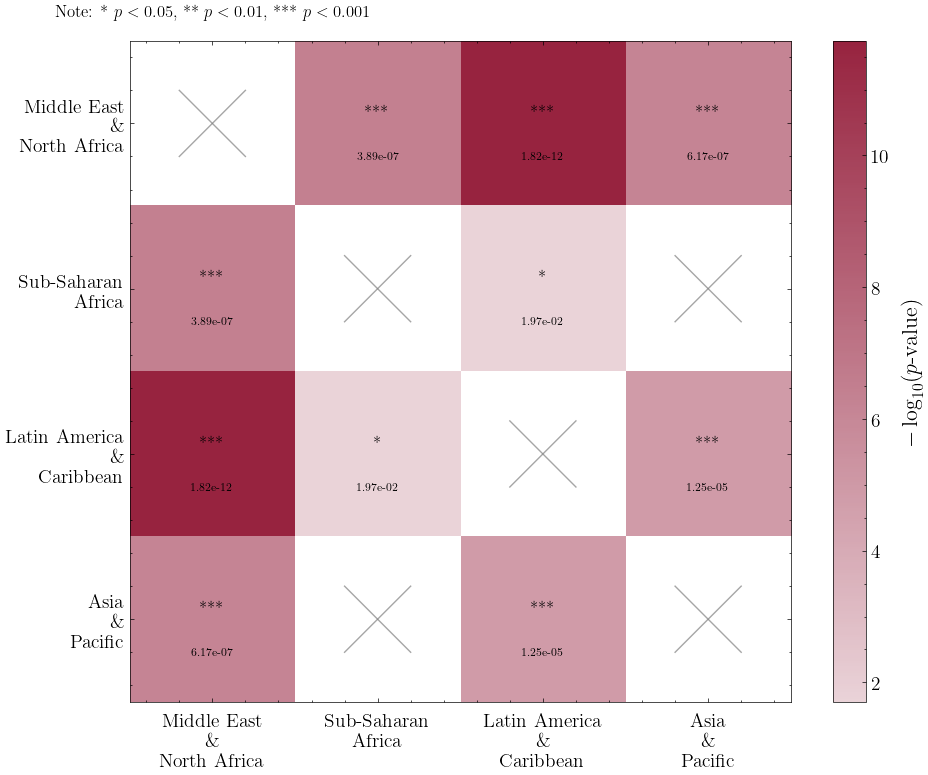

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, to_rgba

# # Define regions with LaTeX formatting
regions = [
    'Middle East\n\\&\nNorth Africa',
    'Sub-Saharan\nAfrica',
    'Latin America\n\\&\nCaribbean',
    'Asia\n\\&\nPacific'
]

# Edge data with LaTeX formatting
results = {
    'Middle East\n\\&\nNorth Africa vs Sub-Saharan\nAfrica': {
        'p_value': [3.8911463495772125e-07, 1.2966416726588392e-01]
    },
    'Middle East\n\\&\nNorth Africa vs Latin America\n\\&\nCaribbean': {
        'p_value': [4.150457755258685e-12, 1.8153256675645935e-12]
    },
    'Middle East\n\\&\nNorth Africa vs Asia\n\\&\nPacific': {
        'p_value': [6.167362659459386e-07, 1.2454525304783637e-04]
    },
    'Sub-Saharan\nAfrica vs Latin America\n\\&\nCaribbean': {
        'p_value': [1.974678618427894e-02, 5.1753820629591996e-02]
    },
    'Sub-Saharan\nAfrica vs Asia\n\\&\nPacific': {
        'p_value': [4.72738434098148e-01, 3.030528452407919e-01]
    },
    'Latin America\n\\&\nCaribbean vs Asia\n\\&\nPacific': {
        'p_value': [3.077425553083879e-03, 1.2450486874704403e-05]
    }
}

base_color = '#97233F'  # Burgundy
rgb_base = to_rgba(base_color)
colors = [(rgb_base[0], rgb_base[1], rgb_base[2], alpha) for alpha in np.linspace(0.2, 1, 100)]
custom_cmap = LinearSegmentedColormap.from_list('custom', colors)

# Create the matrix
n_regions = len(regions)
heatmap_data = np.zeros((n_regions, n_regions))
mask = np.zeros((n_regions, n_regions), dtype=bool)
p_values_text = np.full((n_regions, n_regions), '', dtype=object)
significance_markers = np.full((n_regions, n_regions), '', dtype=object)

# Fill the matrices
for i, reg1 in enumerate(regions):
    for j, reg2 in enumerate(regions):
        if i != j:
            key = f"{reg1} vs {reg2}"
            rev_key = f"{reg2} vs {reg1}"
            
            if key in results:
                p_val = min(results[key]['p_value'])
            elif rev_key in results:
                p_val = min(results[rev_key]['p_value'])
            else:
                mask[i, j] = True
                continue
                
            if p_val >= 0.05:
                mask[i, j] = True
            else:
                heatmap_data[i, j] = -np.log10(p_val)
                p_values_text[i, j] = f'{p_val:.2e}'
                if p_val < 0.001:
                    significance_markers[i, j] = '***'
                elif p_val < 0.01:
                    significance_markers[i, j] = '**'
                elif p_val < 0.05:
                    significance_markers[i, j] = '*'
        else:
            mask[i, j] = True

plt.figure(figsize=(10, 8))
plt.rcParams['font.size'] = 12
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['text.usetex'] = True

masked_data = np.ma.array(heatmap_data, mask=mask)
custom_cmap.set_bad('white')

im = plt.imshow(masked_data, cmap=custom_cmap, aspect='equal')

# Add crosses for masked cells
for i in range(n_regions):
    for j in range(n_regions):
        if mask[i, j]:
            plt.plot([j-0.2, j+0.2], [i-0.2, i+0.2], 'gray', linewidth=1, alpha=0.7)
            plt.plot([j-0.2, j+0.2], [i+0.2, i-0.2], 'gray', linewidth=1, alpha=0.7)
        else:
            # Add significance markers
            plt.text(j, i-0.1, significance_markers[i, j],
                    ha='center', va='center', color='black', fontsize=12)
            # Add p-values
            if p_values_text[i, j]:
                plt.text(j, i+0.2, p_values_text[i, j],
                        ha='center', va='center', color='black', fontsize=8)

plt.colorbar(im, label='$-\log_{10}(p$-value)')
plt.xticks(range(len(regions)), regions)
plt.yticks(range(len(regions)), regions)


# Add note saying what *, **, *** and X (no significance) mean under the graph
plt.text(0, -0.675, 'Note: * $p < 0.05$, ** $p < 0.01$, *** $p < 0.001$',
         ha='center', va='center', fontsize=12)
plt.tight_layout()

plt.savefig('figs/Chow_Test_Heatmap.pdf', bbox_inches='tight')
plt.show()

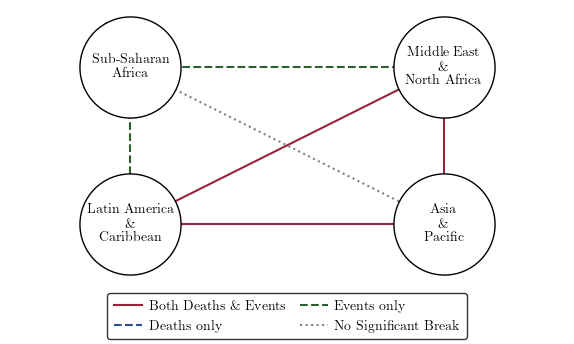

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import scienceplots

plt.style.use(['science'])

plt.figure(figsize=(6, 4))

G = nx.Graph()

# Define regions with LaTeX formatting
regions = [
    'Middle East\n\\&\nNorth Africa',
    'Sub-Saharan\nAfrica',
    'Latin America\n\\&\nCaribbean',
    'Asia\n\\&\nPacific'
]

for region in regions:
    G.add_node(region)

# Custom layout - scaled square formation
pos = {
    'Middle East\n\\&\nNorth Africa': (0.5, 0.5),
    'Sub-Saharan\nAfrica': (-0.5, 0.5),
    'Latin America\n\\&\nCaribbean': (-0.5, -0.5),
    'Asia\n\\&\nPacific': (0.5, -0.5)
}

# Function to determine line style based on death/events significance
def get_line_properties(events_p, death_p,):
    if death_p < 0.05 and events_p < 0.05:
        return '#97233F', 'solid', 'Both'
    elif death_p < 0.05:
        return '#2D4B8E', 'dashed', 'Deaths only'
    elif events_p < 0.05:
        return '#2C5F2D', 'dashed', 'Events only'
    else:
        return 'gray', 'dotted', 'None'

# Edge data with LaTeX formatting
edges_data = {
    ('Middle East\n\\&\nNorth Africa', 'Sub-Saharan\nAfrica'): 
        (3.8911463495772125e-07, 0.12966416726588392),
    ('Middle East\n\\&\nNorth Africa', 'Latin America\n\\&\nCaribbean'): 
        (4.150457755258685e-12, 1.8153256675645935e-12),
    ('Middle East\n\\&\nNorth Africa', 'Asia\n\\&\nPacific'): 
        (6.167362659459386e-07, 0.00012454525304783637),
    ('Sub-Saharan\nAfrica', 'Latin America\n\\&\nCaribbean'): 
        (0.01974678618427894, 0.051753820629591996),
    ('Sub-Saharan\nAfrica', 'Asia\n\\&\nPacific'): 
        (0.472738434098148, 0.3030528452407919),
    ('Latin America\n\\&\nCaribbean', 'Asia\n\\&\nPacific'): 
        (0.003077425553083879, 1.2450486874704403e-05)
}


for (reg1, reg2), (p1, p2) in edges_data.items():
    color, style, label = get_line_properties(p1, p2)
    x1, y1 = pos[reg1]
    x2, y2 = pos[reg2]
    plt.plot([x1, x2], [y1, y2], 
             color=color, 
             linestyle=style,
             linewidth=1.5,
             zorder=1)

node_size = 5300
nodes = nx.draw_networkx_nodes(G, pos, 
                             node_color='white', 
                             node_size=node_size,
                             edgecolors='black',
                             linewidths=1)

nx.draw_networkx_labels(G, pos, font_size=10)

legend_elements = [
    plt.Line2D([0], [0], color='#97233F', linestyle='solid', linewidth=1.5,
               label='Both Deaths \& Events'),
    plt.Line2D([0], [0], color='#2D4B8E', linestyle='dashed', linewidth=1.5,
               label='Deaths only'),
    plt.Line2D([0], [0], color='#2C5F2D', linestyle='dashed', linewidth=1.5,
               label='Events only'),
    plt.Line2D([0], [0], color='gray', linestyle='dotted', linewidth=1.5,
               label='No Significant Break')
]



plt.legend(handles=legend_elements,
          bbox_to_anchor=(0.5, 0),
          loc='upper center',
          ncol=2,
          frameon=True,
          fontsize=10,
          borderpad=0.5,
          handletextpad=0.5,
          columnspacing=1.0)


plt.axis('off')

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)

# Set axis limits to ensure nodes are visible
plt.xlim(-0.9, 0.9)
plt.ylim(-0.9, 0.9)

plt.savefig('figs/structural_breaks_network.pdf', bbox_inches='tight')

plt.show()

---